<a href="https://colab.research.google.com/github/lpaolariosm/Investigaci-n-de-Operaciones-/blob/main/Proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style="color:red;">  ORGANIZACIÓN DE UN CONCIERTO </span>
<span style="color:black;"></span>

## 1. Introducción

En este proyecto se modela la planificación de un concierto mediante el método de la Ruta Crítica (CPM). Para ello:

- Se identifican las actividades clave (rentar lugar, contratar sonido, ensayo, campaña en redes y el concierto final).

- Se establece la duración de cada actividad y sus dependencias.

- Se construye la red en Python utilizando la librería NetworkX.

- Se calculan las fechas tempranas, tardías, holguras y la ruta crítica que determina la duración mínima del proyecto.

## 2. Tabla de Actividades

| ID | Actividad                     | Duración (días) | Predecesores |
|----|-------------------------------|-----------------|--------------|
| A  | Definir presupuesto y concepto|        2        | –            |
| B  | Rentar el lugar               |        2        | A            |
| C  | Contratar artistas            |        3        | A            |
| D  | Logística técnica             |        3        | B, C         |
| E  | Promoción del evento          |        2        | A            |
| F  | Ensayo general                |        4        | C, D         |
| G  | Venta de boletos              |        5        | E            |
| H  | Concierto final               |        1        | F, G         |

## 3. Construcción de la red con NetworkX

En este paso se representa el proyecto como un grafo dirigido (DAG) en Python usando la librería NetworkX.
Cada nodo corresponde a una actividad con su duración, y cada arista representa la dependencia entre actividades.
Al dibujar el grafo, podemos visualizar cómo fluye el proyecto desde el inicio (A) hasta el concierto final (H).

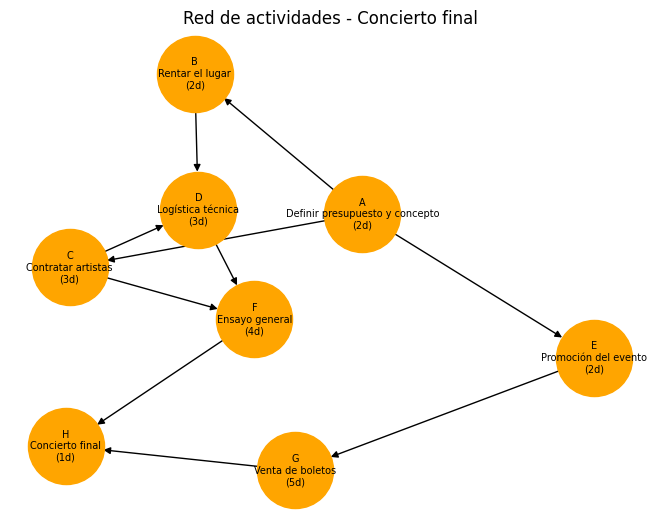

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Definir actividades
actividades = {
    "A": ("Definir presupuesto y concepto", 2),
    "B": ("Rentar el lugar", 2),
    "C": ("Contratar artistas", 3),
    "D": ("Logística técnica", 3),
    "E": ("Promoción del evento", 2),
    "F": ("Ensayo general", 4),
    "G": ("Venta de boletos", 5),
    "H": ("Concierto final", 1)
}

# Definir dependencias
dependencias = [
    ("A", "B"),
    ("A", "C"),
    ("A", "E"),
    ("B", "D"),
    ("C", "D"),
    ("C", "F"),
    ("D", "F"),
    ("E", "G"),
    ("F", "H"),
    ("G", "H")
]

# Crear grafo
G = nx.DiGraph()
for nid, (name, dur) in actividades.items():
    G.add_node(nid, name=name, duration=dur)
G.add_edges_from(dependencias)

# Dibujar red
pos = nx.spring_layout(G, seed=42)
labels = {n: f"{n}\n{G.nodes[n]['name']}\n({G.nodes[n]['duration']}d)" for n in G.nodes()}
nx.draw(G, pos, with_labels=False, arrows=True, node_color="orange", node_size=3000)
nx.draw_networkx_labels(G, pos, labels, font_size=7)
plt.title("Red de actividades - Concierto final")
plt.show()

## 4. Cálculo de fechas tempranas, tardías y ruta crítica

En este paso se aplican las reglas del CPM:

Se calcula el inicio temprano (ES) y fin temprano (EF) recorriendo la red en orden.

Se calculan el fin tardío (LF) y inicio tardío (LS) recorriendo la red en sentido inverso.

La holgura se obtiene como diferencia entre LS y ES.

Las actividades con holgura = 0 forman la ruta crítica, que fija la duración mínima del proyecto.

Duración mínima del proyecto: 13 días
Ruta crítica: A → C → D → F → H


,ID,Actividad,Duración,ES,EF,LS,LF,Holgura,Crítica
0,A,Definir presupuesto y concepto,2,0,2,0,2,0,Sí
1,B,Rentar el lugar,2,2,4,3,5,1,No
2,C,Contratar artistas,3,2,5,2,5,0,Sí
3,E,Promoción del evento,2,2,4,5,7,3,No
4,D,Logística técnica,3,5,8,5,8,0,Sí
5,G,Venta de boletos,5,4,9,7,12,3,No
6,F,Ensayo general,4,8,12,8,12,0,Sí
7,H,Concierto final,1,12,13,12,13,0,Sí


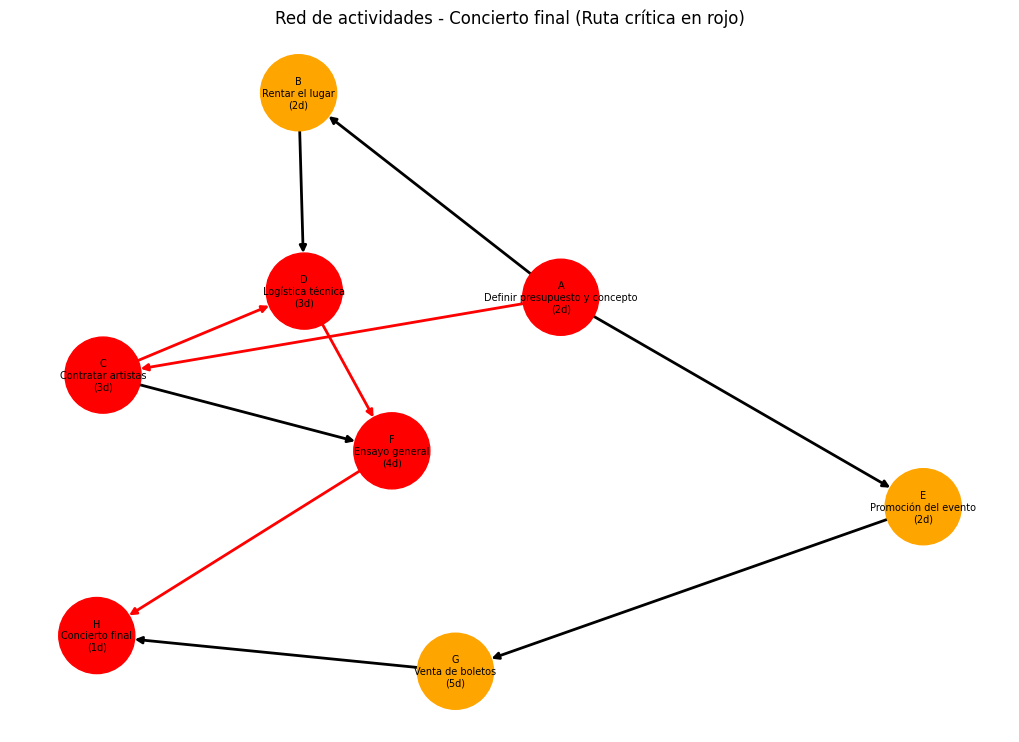

In [ ]:
import pandas as pd


# Calcular ES, EF, LS, LF
topo = list(nx.topological_sort(G))
ES, EF = {}, {}
for n in topo:
    preds = list(G.predecessors(n))
    ES[n] = max(EF[p] for p in preds) if preds else 0
    EF[n] = ES[n] + G.nodes[n]["duration"]

duracion_proyecto = max(EF.values())

LF, LS = {}, {}
for n in reversed(topo):
    succs = list(G.successors(n))
    LF[n] = min(LS[s] for s in succs) if succs else duracion_proyecto
    LS[n] = LF[n] - G.nodes[n]["duration"]

slack = {n: LS[n] - ES[n] for n in G.nodes()}
criticos = [n for n in G.nodes() if slack[n] == 0]

# Crear dataframe de resultados
df = pd.DataFrame([
    [n, G.nodes[n]["name"], G.nodes[n]["duration"], ES[n], EF[n], LS[n], LF[n], slack[n], "Sí" if n in criticos else "No"]
    for n in topo
], columns=["ID", "Actividad", "Duración", "ES", "EF", "LS", "LF", "Holgura", "Crítica"])

print("Duración mínima del proyecto:", duracion_proyecto, "días")
print("Ruta crítica:", " → ".join(criticos))
display(df)

# ruta crítica en rojo
pos = nx.spring_layout(G, seed=42)

node_colors = ["red" if n in criticos else "orange" for n in G.nodes()]
edge_colors = []
for u, v in G.edges():
    if u in criticos and v in criticos and ES[v] == EF[u]:
        edge_colors.append("red")
    else:
        edge_colors.append("black")

labels = {n: f"{n}\n{G.nodes[n]['name']}\n({G.nodes[n]['duration']}d)" for n in G.nodes()}

plt.figure(figsize=(10,7))
nx.draw(G, pos, with_labels=False, arrows=True,
        node_color=node_colors, edge_color=edge_colors,
        node_size=3000, width=2)
nx.draw_networkx_labels(G, pos, labels, font_size=7)
plt.title("Red de actividades - Concierto final (Ruta crítica en rojo)")
plt.show()

##5. Listado de todas las trayectorias y sus duraciones

En este paso lo que buscamos es ver todas las posibles rutas que existen desde la primera actividad (A: Definir presupuesto y concepto) hasta llegar al final del proyecto (H: Concierto final). Cada ruta representa una forma en la que el proyecto puede avanzar, dependiendo de qué actividades se encadenen primero.

La idea es:

- Detectar todos esos caminos posibles dentro de la red.

- Calcular cuánto tiempo duraría cada camino, sumando la duración de las actividades que lo componen.

De esta manera no solo encontramos la ruta crítica, sino que también podemos comparar con las otras trayectorias que existen. Para lograrlo usamos un código en Python que se encarga de buscar todos los caminos y calcular sus duraciones automáticamente.

In [ ]:
import networkx as nx

# Duraciones de cada actividad
durations = {
    "A": 2, "B": 2, "C": 3, "D": 3,
    "E": 2, "F": 4, "G": 5, "H": 1
}

# Crear grafo dirigido
G = nx.DiGraph()

# Agregar dependencias
dependencies = [
    ("A", "B"), ("A", "C"), ("B", "D"), ("C", "D"),
    ("A", "E"), ("C", "F"), ("D", "F"),
    ("E", "G"), ("F", "H"), ("G", "H")
]
G.add_edges_from(dependencies)

# Encontrar todos los caminos de inicio (A) a fin (H)
all_paths = list(nx.all_simple_paths(G, source="A", target="H"))

# Calcular duración de cada trayectoria
paths_with_durations = []
for path in all_paths:
    total_time = sum(durations[task] for task in path)
    paths_with_durations.append((path, total_time))

# Imprimir resultados
for path, time in paths_with_durations:
    print("Trayectoria:", " → ".join(path), "| Duración:", time, "días")

Trayectoria: A → B → D → F → H | Duración: 12 días
Trayectoria: A → C → D → F → H | Duración: 13 días
Trayectoria: A → C → F → H | Duración: 10 días
Trayectoria: A → E → G → H | Duración: 10 días


Con este procedimiento podemos ver claramente todas las trayectorias posibles del proyecto y la duración total de cada una. Esto nos ayuda a comparar las rutas y entender cuáles son más cortas y cuáles más largas, además de identificar de forma sencilla cuál es la ruta crítica que marca el tiempo mínimo en que se puede terminar todo el proyecto.

##6. Visualización del grafo con la ruta crítica resaltada
En este paso ya no solo vamos a ver la red de actividades como en el punto 3, sino que ahora la pintamos resaltando la ruta crítica. Básicamente usamos la misma lógica de antes para armar el grafo, pero aprovechamos los cálculos de ES, EF, LS, LF y holgura que obtuvimos en el punto 4. Con eso podemos marcar en rojo las actividades que no tienen margen de retraso y que son las que determinan la duración total del proyecto.

Duración mínima del proyecto: 13 días
Ruta crítica (orden topológico): A → C → D → F → H

Aristas críticas: [('A', 'C'), ('C', 'D'), ('D', 'F'), ('F', 'H')]


,ID,Actividad,Duración,ES,EF,LS,LF,Holgura,Crítica
0,A,Definir presupuesto y concepto,2,0,2,0,2,0,Sí
1,B,Rentar el lugar,2,2,4,3,5,1,No
2,C,Contratar artistas,3,2,5,2,5,0,Sí
3,E,Promoción del evento,2,2,4,5,7,3,No
4,D,Logística técnica,3,5,8,5,8,0,Sí
5,G,Venta de boletos,5,4,9,7,12,3,No
6,F,Ensayo general,4,8,12,8,12,0,Sí
7,H,Concierto final,1,12,13,12,13,0,Sí


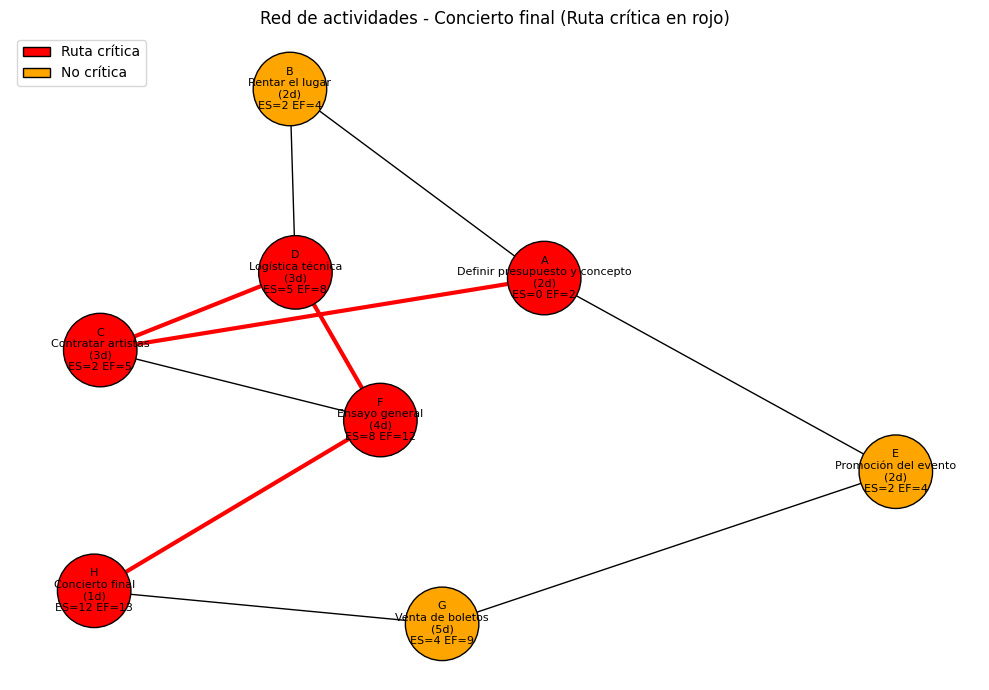


Todas las trayectorias A → H y sus duraciones:
Trayectoria: A → B → D → F → H | Duración: 12 días
Trayectoria: A → C → D → F → H | Duración: 13 días
Trayectoria: A → C → F → H | Duración: 10 días
Trayectoria: A → E → G → H | Duración: 10 días


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch

# ------------- 1) Definición de actividades y dependencias -------------
actividades = {
    "A": ("Definir presupuesto y concepto", 2),
    "B": ("Rentar el lugar", 2),
    "C": ("Contratar artistas", 3),
    "D": ("Logística técnica", 3),
    "E": ("Promoción del evento", 2),
    "F": ("Ensayo general", 4),
    "G": ("Venta de boletos", 5),
    "H": ("Concierto final", 1)
}

dependencias = [
    ("A", "B"),
    ("A", "C"),
    ("A", "E"),
    ("B", "D"),
    ("C", "D"),
    ("C", "F"),
    ("D", "F"),
    ("E", "G"),
    ("F", "H"),
    ("G", "H")
]

# ------------- 2) Crear grafo dirigido y añadir nodos/aristas -------------
G = nx.DiGraph()
for nid, (name, dur) in actividades.items():
    G.add_node(nid, name=name, duration=dur)
G.add_edges_from(dependencias)

# ------------- 3) Cálculo de ES, EF (avance forward) -------------
topo = list(nx.topological_sort(G))
ES, EF = {}, {}
for n in topo:
    preds = list(G.predecessors(n))
    ES[n] = max(EF[p] for p in preds) if preds else 0
    EF[n] = ES[n] + G.nodes[n]["duration"]

# ------------- 4) Cálculo de LF, LS (retroceso/backward) -------------
duracion_proyecto = max(EF.values())
LF, LS = {}, {}
for n in reversed(topo):
    succs = list(G.successors(n))
    LF[n] = min(LS[s] for s in succs) if succs else duracion_proyecto
    LS[n] = LF[n] - G.nodes[n]["duration"]

# ------------- 5) Holgura y actividades críticas -------------
holgura = {n: LS[n] - ES[n] for n in G.nodes()}
criticos = [n for n in topo if holgura[n] == 0]  # en orden topológico

# ------------- 6) Detectar aristas críticas (entre nodos críticos y sin margen) -------------
crit_edges = []
for u, v in G.edges():
    if u in criticos and v in criticos and EF[u] == ES[v]:
        crit_edges.append((u, v))

# ------------- 7) Mostrar resultados en pantalla y DataFrame -------------
print("Duración mínima del proyecto:", duracion_proyecto, "días")
print("Ruta crítica (orden topológico):", " → ".join(criticos))
print("\nAristas críticas:", crit_edges)

df = pd.DataFrame([
    [n, G.nodes[n]["name"], G.nodes[n]["duration"],
     ES[n], EF[n], LS[n], LF[n], holgura[n], "Sí" if n in criticos else "No"]
    for n in topo
], columns=["ID", "Actividad", "Duración", "ES", "EF", "LS", "LF", "Holgura", "Crítica"])
display(df)  # si usas Jupyter; en consola puedes usar print(df)

# ------------- 8) Dibujo del grafo con la ruta crítica resaltada -------------
pos = nx.spring_layout(G, seed=42)  # layout consistente

# colores y grosores
nodes_order = list(G.nodes())
node_colors = ["red" if n in criticos else "orange" for n in nodes_order]
edge_colors = ["red" if (u, v) in crit_edges else "black" for u, v in G.edges()]
edge_widths = [3 if (u, v) in crit_edges else 1 for u, v in G.edges()]

# etiquetas de nodos (puedes ajustar para mostrar menos info si queda muy cargado)
labels = {
    n: f"{n}\n{G.nodes[n]['name']}\n({G.nodes[n]['duration']}d)\nES={ES[n]} EF={EF[n]}"
    for n in G.nodes()
}

plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(G, pos, nodelist=nodes_order, node_color=node_colors,
                       node_size=2800, edgecolors="k", linewidths=1.0)
nx.draw_networkx_edges(G, pos, edgelist=list(G.edges()), edge_color=edge_colors,
                       width=edge_widths, arrowsize=20, arrowstyle='->')
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

# leyenda personalizada
legend_handles = [Patch(facecolor='red', edgecolor='k', label='Ruta crítica'),
                  Patch(facecolor='orange', edgecolor='k', label='No crítica')]
plt.legend(handles=legend_handles, loc='upper left')

plt.title("Red de actividades - Concierto final (Ruta crítica en rojo)")
plt.axis('off')
plt.tight_layout()

# Opcional: guardar la imagen
plt.savefig("ruta_critica_concierto.png", dpi=150)
plt.show()

# ------------- 9) (Opcional) Listado de todas las trayectorias A -> H y duraciones -------------
all_paths = list(nx.all_simple_paths(G, source="A", target="H"))
durations = {n: G.nodes[n]["duration"] for n in G.nodes()}

print("\nTodas las trayectorias A → H y sus duraciones:")
for path in all_paths:
    t = sum(durations[n] for n in path)
    print("Trayectoria:", " → ".join(path), "| Duración:", t, "días")

Como resultado obtenemos un diagrama donde se ven todas las actividades, pero lo más importante es que la ruta crítica aparece en rojo. Esto hace más fácil identificar de un vistazo cuáles son las tareas que no se pueden atrasar, ya que cualquier demora en ellas afecta directamente la fecha final del concierto.

##7. Conclusión

El uso del método de la Ruta Crítica (CPM) en este proyecto nos permitió ver de manera clara cuáles son las actividades que realmente definen la duración total del concierto y cuáles cuentan con cierta flexibilidad. En otras palabras, no todas las tareas tienen el mismo peso: algunas pueden moverse un poco sin problema, mientras que otras no admiten retraso alguno porque impactarían directamente en la fecha final.

Con este ejemplo del concierto quedó más evidente la utilidad de la herramienta. Actividades como “Definir presupuesto”, “Contratar artistas”, “Ensayo general” y “Concierto final” forman parte de la ruta crítica, lo que significa que cualquier demora en ellas se traduce en un atraso de todo el proyecto. Por otro lado, acciones como la promoción o la venta de boletos tienen algo de holgura y permiten mayor flexibilidad.

En resumen, aplicar este método nos ayuda a organizar mejor el trabajo, asignar prioridades y enfocar los recursos en las tareas que no se pueden aplazar. Así, no solo tenemos un calendario más realista, sino también un panorama claro de qué actividades son estratégicas para asegurar que el evento se lleve a cabo en tiempo y forma.